In [1]:
# Bibliotecas
import sys, pandas as pd, numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns, numpy as np, os
from os.path import exists
sys.path.append('../')

# Ambiente
from env.DrivingLicense import DrivingLicense

# Modelos
from models.Neutral_VI import Neutral_VI
from models.Neutral_PI import Neutral_PI

from models.ExponentialUtility_RSPI import ExponentialUtility_RSPI
from models.ExponentialUtility_RSVI import ExponentialUtility_RSVI

from models.PieceLinear_RSPI import PieceLinear_RSPI
from models.PieceLinear_RSVI import PieceLinear_RSVI

%load_ext autoreload
%autoreload 2

# Driving License

This scenario describes a candidate that wants to take his 
driving license, and he has two choices: take lessons or do the 
practical exam. However, the more lesson he takes, the greater 
is the chance to pass in the practical exam. The candidate 
wants to minimize his cost to take the driving license. The 
question for this problem is: how many hours of lessons he 
must take before taking the practical exam? 

The candidate 
pays a cost of 2 for each practical exam and the cost to 
have lessons is 1. The candidate can take at most 4 hours of 
lessons before each practical exam and can only accumulates 
a maximum of 10 hours of experience. 

The chance of being 
approved in the practical exam depends on the previous 
accumulated experience (x) and current number of lessons 
taken (y). The function that returns the probability to being 
approved in the practical exam is: p(x, y) = 0.08x + 0.04y .


To model this scenario, we use a GD-RSMDP with 11 states 
and 5 actions. The states {0, 1, ..., 10} keep information of the 
number of hours accumulated before the current lessons and a 
goal state sG which represents that the agent has been aproved. 
The actions {0, 1, ..., 4} show the number of lessons to take 
before each practical exam. 

In [2]:
# Configurações do ambiente
states, actions = 11, 5
epsilon = 0.0001

dl = DrivingLicense(states, actions)
T = dl.build_transition_probabilities()
# C = {0: 2, 1: 3, 2: 4, 3: 5, 4: 6}
C = {0: 4, 1: 6, 2: 8, 3: 10, 4: 12}

config_reduzida = False

# Configurações de processamento
run_neutral_vi = False
run_neutral_pi = False
run_EUF_RSVI = True
run_EUF_RSPI = True
run_PWL_RSVI = True

# Configurações dos modelos
discount_factor = 0.999

In [3]:
def run_driving_license(model, model_name, **kwargs):
    if model_name == 'Neutral-VI' or model_name == 'Neutral-PI':
        epsilon, discount_factor = kwargs['epsilon'], kwargs['discount_factor']
        rdl = model(dl, T, C, actions, discount_factor=discount_factor, epsilon=epsilon)
    elif model_name == 'EUF_RSVI':
        vl_lambda, epsilon = kwargs['vl_lambda'], kwargs['epsilon']
        rdl = model(dl, T, C, vl_lambda, actions, epsilon=epsilon)
    elif model_name == 'EUF_RSPI':
        vl_lambda, epsilon, explogsum = kwargs['vl_lambda'], kwargs['epsilon'], kwargs['explogsum']
        rdl = model(dl, T, C, vl_lambda, actions, epsilon=epsilon, explogsum=explogsum)
    elif model_name == 'PL_RSVI':
        k, alpha, gamma, epsilon = kwargs['k'], kwargs['alpha'], kwargs['gamma'], kwargs['epsilon']
        rdl = model(dl, T, C, k=k, alpha=alpha, gamma=gamma,
                         num_actions=actions, epsilon=epsilon)
    
    if 'PI' in kwargs:
        acc_costs = rdl.calculate_value_for_policy(kwargs['PI'], 0)
        return acc_costs
    else:
        num_iterations, time = rdl.run_converge()
    
    if kwargs['_log']: print(f'Número de Iterações: {num_iterations}')
    if kwargs['_log']: print(f'Tempo de Execução: {time}s')
    
    return rdl

# Value Iteration

In [4]:
if run_neutral_vi:
    rdl = run_driving_license(Neutral_VI, 'Neutral-VI', discount_factor=discount_factor, epsilon=epsilon, _log=False)
    display(rdl.V)
    display(rdl.PI)

# Policy Iteration

In [5]:
if run_neutral_pi:
    rdl = run_driving_license(Neutral_PI, 'Neutral-PI', discount_factor=discount_factor, epsilon=epsilon, _log=False)
    display(rdl.V)
    display(rdl.PI)

# Value Iteration - Exponential Utility Function for RS-MDP

In [6]:
if run_EUF_RSVI:
    EUF_RSVI = {}
    
    if config_reduzida:
        range_lambda = [-0.2, 0.5]
    else:
        range_lambda = [-0.2, -0.15, -0.1, -0.05, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 
                        0.6, 0.7, 0.8]
        
    for vl_lambda in range_lambda:
        print(f'Processando: Lambda [{vl_lambda}]', end='\r')
        EUF_RSVI[vl_lambda] = \
            run_driving_license(model=ExponentialUtility_RSVI, model_name='EUF_RSVI',
            vl_lambda=vl_lambda, epsilon=epsilon, _log=False)
        
    display(EUF_RSVI.keys())
    
    for k in EUF_RSVI.keys():
        print(f'Política para [{k}]: {EUF_RSVI[k].PI}')

dict_keys([-0.2, -0.15, -0.1, -0.05, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8])

Política para [-0.2]: {0: 3, 1: 2, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 'sG': 0}
Política para [-0.15]: {0: 4, 1: 2, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 'sG': 0}
Política para [-0.1]: {0: 4, 1: 3, 2: 2, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 'sG': 0}
Política para [-0.05]: {0: 4, 1: 3, 2: 2, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 'sG': 0}
Política para [0.05]: {0: 4, 1: 4, 2: 3, 3: 2, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 'sG': 0}
Política para [0.1]: {0: 4, 1: 4, 2: 4, 3: 3, 4: 2, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 'sG': 0}
Política para [0.15]: {0: 4, 1: 4, 2: 4, 3: 3, 4: 2, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 'sG': 0}
Política para [0.2]: {0: 4, 1: 4, 2: 4, 3: 4, 4: 3, 5: 2, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 'sG': 0}
Política para [0.25]: {0: 4, 1: 4, 2: 4, 3: 4, 4: 3, 5: 2, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 'sG': 0}
Política para [0.3]: {0: 4, 1: 4, 2: 4, 3: 4, 4: 4, 5: 3, 6: 2, 7: 1, 8: 0, 9: 0, 10: 0, 'sG': 0}
Política pa

# Exponential Utility Function for RS-MDP

In [7]:
if run_EUF_RSPI:
    EUF_RSPI = {}
    explogsum = True
    
    if config_reduzida:
        range_lambda = [-0.2, -0.1, 0.2]
    else:
        range_lambda = [-0.2, -0.15, -0.1, -0.05, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 
                        0.6, 0.65, 0.7, 0.8, 0.9, 1]
    
    for vl_lambda in range_lambda:
        print(f'Processando: Lambda [{vl_lambda}]', end='\r')
        EUF_RSPI[vl_lambda] = \
            run_driving_license(model=ExponentialUtility_RSPI, model_name='EUF_RSPI',
            vl_lambda=vl_lambda, epsilon=epsilon, explogsum=explogsum, _log=False)
        
    display(EUF_RSPI.keys())
    
    for k in EUF_RSPI.keys():
        print(f'Política para [{k}]: {EUF_RSPI[k].PI.values()}')

dict_keys([-0.2, -0.15, -0.1, -0.05, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1])

Política para [-0.2]: dict_values([4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 0])
Política para [-0.15]: dict_values([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0])
Política para [-0.1]: dict_values([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0])
Política para [-0.05]: dict_values([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0])
Política para [0.05]: dict_values([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0])
Política para [0.1]: dict_values([4, 4, 4, 4, 4, 4, 4, 3, 2, 1, 0, 0])
Política para [0.15]: dict_values([4, 4, 4, 4, 4, 3, 2, 1, 0, 0, 0, 0])
Política para [0.2]: dict_values([0, 0, 1, 0, 3, 2, 1, 0, 0, 0, 0, 0])
Política para [0.25]: dict_values([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Política para [0.3]: dict_values([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Política para [0.35]: dict_values([2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Política para [0.4]: dict_values([2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Política para [0.45]: dict_values([3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Política para [0.5]: dict_values([4, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0,

# PieceLinear - RSVI (Risk Sensitive Value Iteration)

In [18]:
if run_PWL_RSVI:
    PWL_RSVI = {}
    df_PWL_RSVI = pd.DataFrame()
    
    if config_reduzida:
        range_k     = [-0.9, 0.9]
    else:
        range_k     = [-0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 
                       0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.925, 0.95, 0.975, 0.99]
    
    gamma       = 1
    range_alpha = [np.round(1/(1+abs(k)), 2) for k in range_k]
    
    for i in range(0, len(range_k)):
        print(f'Processando: K [{range_k[i]}] Alpha [{range_alpha[i]}]', end='\r')
        PWL_RSVI[(range_k[i], gamma, range_alpha[i])] = \
            run_driving_license(model=PieceLinear_RSVI, model_name='PL_RSVI',
            gamma=gamma, k=range_k[i], alpha=range_alpha[i], epsilon=epsilon, _log=False)
        
    display(PWL_RSVI.keys())
    
    for k in PWL_RSVI.keys():
        df_PWL_RSVI = df_PWL_RSVI.append(pd.DataFrame(pd.Series(PWL_RSVI[k].PI, name=f'Policy {k}')).T)
    display(df_PWL_RSVI)

dict_keys([(-0.9, 1, 0.53), (-0.8, 1, 0.56), (-0.7, 1, 0.59), (-0.6, 1, 0.62), (-0.5, 1, 0.67), (-0.4, 1, 0.71), (-0.3, 1, 0.77), (-0.2, 1, 0.83), (-0.1, 1, 0.91), (0.0, 1, 1.0), (0.1, 1, 0.91), (0.2, 1, 0.83), (0.3, 1, 0.77), (0.4, 1, 0.71), (0.5, 1, 0.67), (0.6, 1, 0.62), (0.7, 1, 0.59), (0.8, 1, 0.56), (0.9, 1, 0.53), (0.925, 1, 0.52), (0.95, 1, 0.51), (0.975, 1, 0.51), (0.99, 1, 0.5)])

,0,1,2,3,4,5,6,7,8,9,10,sG
"Policy (-0.9, 1, 0.53)",1,0,0,0,0,0,0,0,0,0,0,0
"Policy (-0.8, 1, 0.56)",2,1,0,0,0,0,0,0,0,0,0,0
"Policy (-0.7, 1, 0.59)",2,1,0,0,0,0,0,0,0,0,0,0
"Policy (-0.6, 1, 0.62)",3,1,0,0,0,0,0,0,0,0,0,0
"Policy (-0.5, 1, 0.67)",3,2,1,0,0,0,0,0,0,0,0,0
"Policy (-0.4, 1, 0.71)",3,2,1,0,0,0,0,0,0,0,0,0
"Policy (-0.3, 1, 0.77)",4,3,1,0,0,0,0,0,0,0,0,0
"Policy (-0.2, 1, 0.83)",4,3,2,1,0,0,0,0,0,0,0,0
"Policy (-0.1, 1, 0.91)",4,3,2,1,0,0,0,0,0,0,0,0
"Policy (0.0, 1, 1.0)",4,4,3,2,1,0,0,0,0,0,0,0


# Comparando Políticas

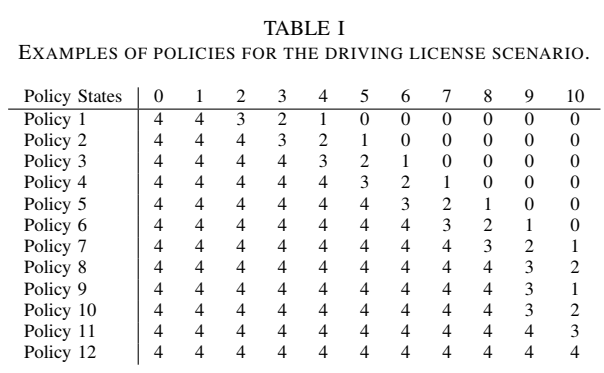

In [50]:
policies = {
    'Policy 1': {0: 4, 1: 4, 2: 3, 3: 2, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 'sG': 0},
    'Policy 2': {0: 4, 1: 4, 2: 4, 3: 3, 4: 2, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 'sG': 0},
    'Policy 3': {0: 4, 1: 4, 2: 4, 3: 4, 4: 3, 5: 2, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 'sG': 0},
    'Policy 4': {0: 4, 1: 4, 2: 4, 3: 4, 4: 4, 5: 3, 6: 2, 7: 1, 8: 0, 9: 0, 10: 0, 'sG': 0},
    'Policy 5': {0: 4, 1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 3, 7: 2, 8: 1, 9: 0, 10: 0, 'sG': 0},
    'Policy 6': {0: 4, 1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 4, 7: 3, 8: 2, 9: 1, 10: 0, 'sG': 0},
    'Policy 7': {0: 4, 1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 4, 7: 4, 8: 3, 9: 2, 10: 1, 'sG': 0},
    'Policy 8': {0: 4, 1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 4, 7: 4, 8: 4, 9: 3, 10: 0, 'sG': 0},
    'Policy 9': {0: 4, 1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 4, 7: 4, 8: 4, 9: 4, 10: 1, 'sG': 0},
    'Policy 10': {0: 4, 1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 4, 7: 4, 8: 4, 9: 4, 10: 2, 'sG': 0},
    'Policy 11': {0: 4, 1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 4, 7: 4, 8: 4, 9: 4, 10: 3, 'sG': 0},
    'Policy 12': {0: 4, 1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 4, 7: 4, 8: 4, 9: 4, 10: 4, 'sG': 0},
    'Policy 13': {0: 4, 1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 4, 7: 3, 8: 2, 9: 1, 10: 4, 'sG': 0}
}

df_policies = pd.DataFrame()
for k in policies.keys():
    df_policies = df_policies.append(pd.DataFrame(pd.Series(policies[k], name=k)).T)
    
display(df_policies)

,0,1,2,3,4,5,6,7,8,9,10,sG
Policy 1,4,4,3,2,1,0,0,0,0,0,0,0
Policy 2,4,4,4,3,2,1,0,0,0,0,0,0
Policy 3,4,4,4,4,3,2,1,0,0,0,0,0
Policy 4,4,4,4,4,4,3,2,1,0,0,0,0
Policy 5,4,4,4,4,4,4,3,2,1,0,0,0
Policy 6,4,4,4,4,4,4,4,3,2,1,0,0
Policy 7,4,4,4,4,4,4,4,4,3,2,1,0
Policy 8,4,4,4,4,4,4,4,4,4,3,0,0
Policy 9,4,4,4,4,4,4,4,4,4,4,1,0
Policy 10,4,4,4,4,4,4,4,4,4,4,2,0


In [51]:
def plot_policy_value(policies, df_res, metric, y_lim_min=12, y_lim_max=100):
    f = figure(figsize=(12, 7), dpi=80)

    for policy in policies.keys():
        if int(policy.replace('Policy ', '')) > 6:
            plt.plot(df_res.index, df_res[policy], '-.', label=policy)
        else:
            plt.plot(df_res.index, df_res[policy], label=policy)

        plt.legend(loc="upper left")
        plt.xlabel(f"{metric}")
        plt.ylabel("Policy Value")

    plt.ylim([y_lim_min, y_lim_max])
    plt.title(f'{metric} Values')
    plt.show()

## Exponential Utility

..\models\ExponentialUtility_RSVI.py:172: RuntimeWarning: overflow encountered in double_scalars
  new_V[S] = np.exp(self._lambda * C) * sum(q)


,Policy 1,Policy 2,Policy 3,Policy 4,Policy 5,Policy 6,Policy 7,Policy 8,Policy 9,Policy 10,Policy 11,Policy 12,Policy 13
-0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.05,55.624168,55.687304,55.936276,56.316095,56.766640,57.253950,57.958118,57.988614,58.386312,58.623340,58.844594,59.048716,58.336000
0.10,31.522314,31.424677,31.615915,31.984063,32.441904,32.942311,33.705010,33.740339,34.174690,34.442485,34.695510,34.927721,34.171114
0.15,24.316359,23.860888,23.926859,24.252197,24.704992,25.213632,26.048861,26.085486,26.567630,26.877025,27.171806,27.436579,26.627449
0.20,22.056224,20.650390,20.458264,20.693061,21.121600,21.631955,22.555574,22.585290,23.127761,23.493418,23.841725,24.140936,23.272522
0.25,27.416535,19.523857,18.757152,18.821253,19.198665,19.700508,20.730116,20.739742,21.356295,21.797512,22.214325,22.544399,21.613107
0.30,314.202093,20.695433,18.078561,17.816744,18.102640,18.582194,19.738186,19.706761,20.414132,20.958312,21.462251,21.810839,20.815740


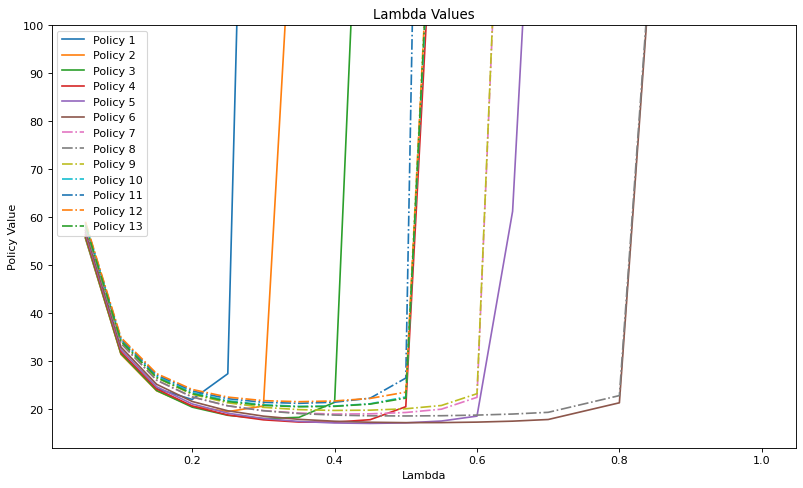

In [52]:
res = {}
df_res = pd.DataFrame()

for policy in policies.keys():
    PI = policies[policy]
    res[policy] = {}
    
    for vl_lambda in range_lambda:
        print(f'{policy} | {vl_lambda}...', end='\r')
        res[policy][vl_lambda] = run_driving_license(model=ExponentialUtility_RSVI, model_name='EUF_RSVI',
            vl_lambda=vl_lambda, epsilon=epsilon, _log=False, PI=PI)
        
    df = pd.DataFrame(pd.Series(res[policy], name=policy))
    df_res[policy] = df

for l in df_res.index:
    df_res.loc[l, :] = np.log(df_res.loc[l, :])/l

display(df_res)
plot_policy_value(policies, df_res, 'Lambda')

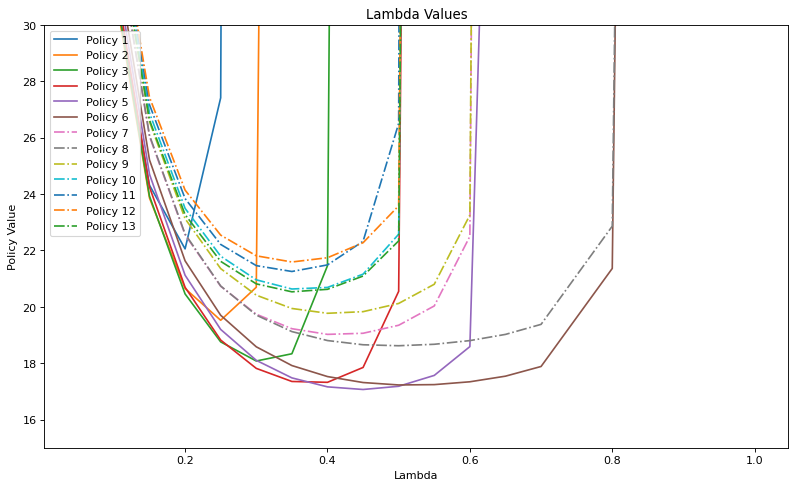

In [53]:
plot_policy_value(policies, df_res, 'Lambda', 15, 30)

In [54]:
# np.log(1-0.88)/4

## Piece-wise Linear

In [41]:
res = {}
df_res = pd.DataFrame()

for policy in policies.keys():
    PI = policies[policy]
    res[policy] = {}
    
    for i in range(0, len(range_k)):
        print(f'{policy} | {range_k[i]}...', end='\r')
        res[policy][range_k[i]] = \
        run_driving_license(model=PieceLinear_RSVI, model_name='PL_RSVI',
            gamma=gamma, k=range_k[i], alpha=range_alpha[i], epsilon=epsilon, _log=False, PI=PI)
        
    df = pd.DataFrame(pd.Series(res[policy], name=policy))
    df_res[policy] = df

# for l in df_res.index:
#     df_res.loc[l, :] = np.log(df_res.loc[l, :])/l

display(df_res)

,Policy 1,Policy 2,Policy 3,Policy 4,Policy 5,Policy 6,Policy 7,Policy 8,Policy 9,Policy 10,Policy 11,Policy 12,Policy 13
-0.900,38.135254,42.348191,46.708548,51.168283,55.496440,59.741994,63.990551,67.157019,67.119070,68.191143,69.259609,70.324991,64.114064
-0.800,40.217319,44.520486,49.110356,53.901718,58.520947,63.012618,67.546596,70.917271,70.830815,71.992484,73.142370,74.283178,67.825785
-0.700,42.334628,46.631723,51.353830,56.380746,61.249748,65.980493,70.829953,74.434343,74.290114,75.556672,76.804152,78.034927,71.315679
-0.600,44.557854,48.764390,53.535585,58.717605,63.796248,68.752513,73.944585,77.807539,77.591276,78.980353,80.339792,81.673265,74.693151
-0.500,46.949720,50.985660,55.728186,60.993944,66.238654,71.401480,76.962514,81.106295,80.800737,82.331245,83.818122,85.266830,78.035783
-0.400,49.575743,53.356416,57.993915,63.273138,68.637392,73.982144,79.939288,84.384687,83.969421,85.661809,87.292061,88.867915,81.403240
-0.300,52.515613,55.948431,60.396695,65.615663,71.046429,76.541727,82.924354,87.691571,87.142685,89.019302,90.809117,92.522932,84.848304
-0.200,55.865495,58.840760,63.006882,68.082677,73.519272,79.124995,85.966176,91.075419,90.365051,92.450503,94.416124,96.276876,88.418601
-0.100,59.751139,62.140330,65.910547,70.747538,76.114972,81.778292,89.116496,94.588313,93.683923,96.005527,98.162738,100.176102,92.166192
0.000,64.345204,65.983447,69.223350,73.700889,78.904585,84.556483,92.437004,98.292877,97.156221,99.744673,102.107856,104.273939,96.146307


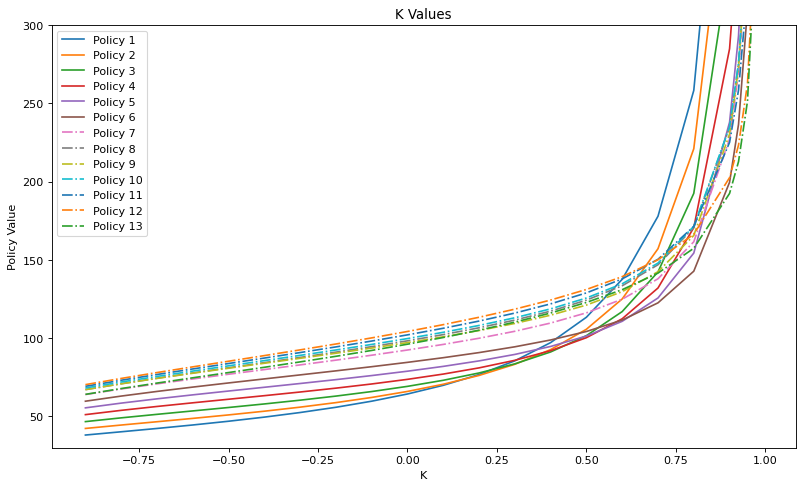

In [42]:
plot_policy_value(policies, df_res, 'K', 30, 300)

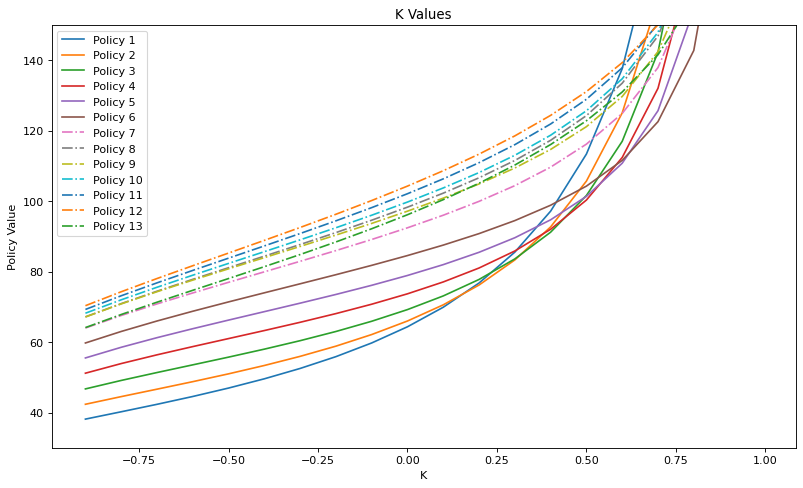

In [43]:
plot_policy_value(policies, df_res, 'K', 30, 150)